Каждый из нас писал в школе и университете изложения, сочинения, рефераты. А значит, в каждом из нас живет великий русский писатель.
В этой работе будем раскрывать свои таланты, находить себя в ряду таких гениев, как Пушкин, Гоголь, Грибоедов

В этой работе
- скачаем корпус текстов 20-ми русских писателей. Каждый текст разобьем на обучающую и тестовую выборки.
- разработаем и обучим нейронную сеть определяющию авторство фрагментов текста (по тестовой выборке)
- скачаем СВОЕ сочинение (или чье-нибудь - есть в архиве). Сделаем из него проверочную выборку
- предложим нейронке предсказать автора сочинения (по проверочной выборке)
- объявим себя великим писателем, например, Гончаровым

Ссылка на архив: https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip

В работе рекомендуется пользоваться материалами из ноутбука практического занятия "Рекуррентные и одномерные сверточные нейронные сети". Допускается выбрать лучший вариант нейронки и адаптировать ее структуру, параметры обучения и формирования датасетов под свои *нужды*

In [ ]:
# Импортируем все необходимые библиотеки
import os
import re
import gdown
import zipfile
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional


In [ ]:
# URL файла на Google Drive
url = 'https://drive.google.com/uc?export=download&id=1rf9lEUGrIw55P15md8XWWTgxxV1XXrsg'

# Имя файла, куда будет сохранён архив
output = '20writers.zip'

# Скачиваем архив с Google Drive
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1rf9lEUGrIw55P15md8XWWTgxxV1XXrsg
From (redirected): https://drive.google.com/uc?export=download&id=1rf9lEUGrIw55P15md8XWWTgxxV1XXrsg&confirm=t&uuid=462da704-ec1d-44da-96df-7b1b6265027e
To: /content/20writers.zip
100%|██████████| 28.8M/28.8M [00:00<00:00, 51.7MB/s]


'20writers.zip'

In [ ]:
# Распаковываем архив
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall()  # Распаковываем в текущую директорию

# Папка с текстами
DATA_DIR = '20writers'  # Путь к подкаталогу

# Проверим содержимое подкаталога 20writers
files = os.listdir(DATA_DIR)
print(f"Files in the directory: {files}")

Files in the directory: ['Gogol.txt', 'Nosov.txt', 'Goncharov.txt', 'Leskov.txt', 'Kaverin.txt', 'Griboedov.txt', 'Kataev.txt', 'Gorky.txt', 'Vasilyev.txt', 'Sholokhov.txt', 'Lermontov.txt', 'Turgenev.txt', 'Tolstoy.txt', 'Belyaev.txt', 'Chekhov.txt', 'Kuprin.txt', 'Pushkin.txt', 'Dostoevsky.txt', 'Bulgakov.txt', 'Pasternak.txt']


In [ ]:
# Списки для хранения данных и меток
texts = []
labels = []

# Чтение и разбиение текста на фрагменты
for filename in os.listdir(DATA_DIR):
    if filename.endswith('.txt') and filename.lower() != 'readme.txt':
        author = filename.replace('.txt', '').strip()
        with open(os.path.join(DATA_DIR, filename), 'r', encoding='utf-8') as f:
            text = f.read().replace('\n', ' ')
            fragments = text.split('.')  # грубое разбиение по предложениям
            fragments = ['.'.join(fragments[i:i+5]) for i in range(0, len(fragments), 5)]  # по 5 предложений
            for frag in fragments:
                if len(frag.split()) > 20:  # чтобы отсеять слишком короткие
                    texts.append(frag)
                    labels.append(author)


In [ ]:
# Проверим содержимое архива
with zipfile.ZipFile(output, 'r') as zip_ref:
    print("Files in the archive:", zip_ref.namelist())

Files in the archive: ['20writers/', '20writers/Belyaev.txt', '20writers/Bulgakov.txt', '20writers/Chekhov.txt', '20writers/Dostoevsky.txt', '20writers/Gogol.txt', '20writers/Goncharov.txt', '20writers/Gorky.txt', '20writers/Griboedov.txt', '20writers/Kataev.txt', '20writers/Kaverin.txt', '20writers/Kuprin.txt', '20writers/Lermontov.txt', '20writers/Leskov.txt', '20writers/Nosov.txt', '20writers/Pasternak.txt', '20writers/Pushkin.txt', '20writers/Sholokhov.txt', '20writers/Tolstoy.txt', '20writers/Turgenev.txt', '20writers/Vasilyev.txt']


In [ ]:
# Проверим, что всё совпадает
assert len(texts) == len(labels), "Нарушено соответствие между текстами и метками!"

# Создание словаря авторов
unique_authors = sorted(list(set(labels)))
author_to_index = {author: idx for idx, author in enumerate(unique_authors)}
y = [author_to_index[a] for a in labels]

In [ ]:
# Преобразование текста в последовательности
VOCAB_SIZE = 20000
MAX_LEN = 500  # Максимальная длина последовательности

# Разделение на обучение и тест
X_train, X_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Преобразуем текст в последовательности чисел
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [ ]:
# One-hot encoding для меток
y_train_cat = to_categorical(y_train, num_classes=len(unique_authors))
y_test_cat = to_categorical(y_test, num_classes=len(unique_authors))

In [ ]:
# Определение модели
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=MAX_LEN))
model.add(LSTM(64, return_sequences=False))  # Уменьшаем размер скрытого состояния
model.add(Dropout(0.5))
model.add(Dense(len(unique_authors), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',  # Можно попробовать другие оптимизаторы
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Обучение модели
history = model.fit(X_train_pad,
                    y_train_cat,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - accuracy: 0.1982 - loss: 2.5842 - val_accuracy: 0.5020 - val_loss: 1.6125
Epoch 2/10
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 78s 21ms/step - accuracy: 0.5955 - loss: 1.3479 - val_accuracy: 0.7140 - val_loss: 0.9689
Epoch 3/10
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - accuracy: 0.8089 - loss: 0.6711 - val_accuracy: 0.7766 - val_loss: 0.7794
Epoch 4/10
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - accuracy: 0.8922 - loss: 0.3803 - val_accuracy: 0.7711 - val_loss: 0.8694
Epoch 5/10
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - accuracy: 0.9334 - loss: 0.2370 - val_accuracy: 0.7763 - val_loss: 0.9035
Epoch 6/10
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 53s 23ms/step - accuracy: 0.9560 - loss: 0.1635 - val_accuracy: 0.7789 - val_loss: 0.9718
Epoch 7/10
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 77s 21ms/step - accuracy: 0.9700 - loss: 0.1113 - val_accuracy: 0.7739 - val_loss: 1.0538
Epoch 8/10
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 81s 20ms/step - accuracy: 0.9769 -

In [ ]:
# Оценка на тестовой выборке
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test_cat)
print(f'Test Accuracy: {test_accuracy:.4f}')

726/726 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7723 - loss: 1.3279
Test Accuracy: 0.7746


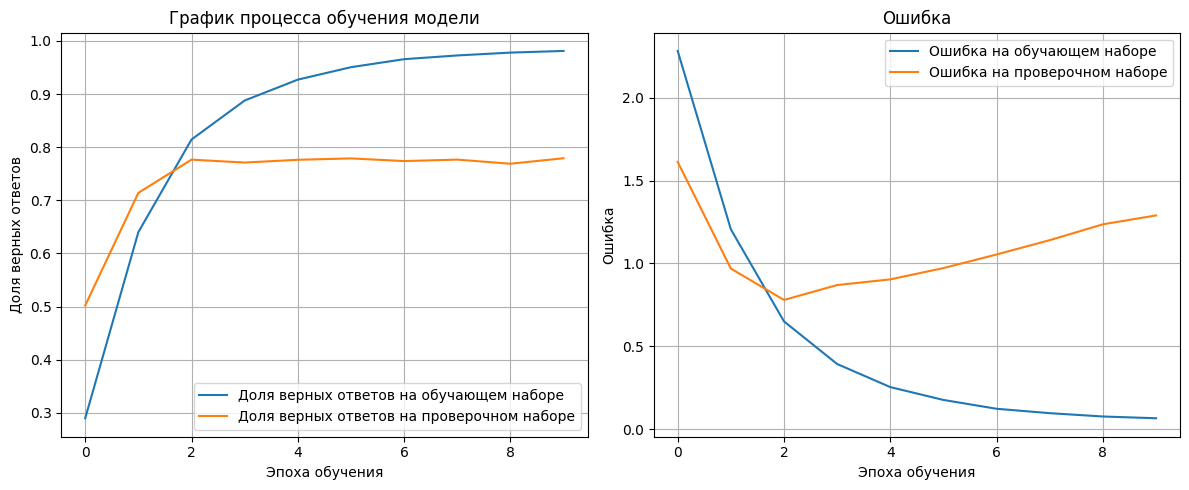

In [ ]:
# График точности (доля верных ответов)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.title('График процесса обучения модели')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.grid(True)

# График функции потерь (ошибка)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.title('Ошибка')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Функция для предсказания автора нового текста
def preprocess_text(text):
    text = text.lower()  # Преобразуем в нижний регистр
    text = text.translate(str.maketrans('', '', string.punctuation))  # Убираем знаки препинания
    return text

def predict_author(new_text, model, tokenizer, maxlen):
    new_text = preprocess_text(new_text)
    new_text_seq = tokenizer.texts_to_sequences([new_text])
    new_text_pad = pad_sequences(new_text_seq, maxlen=maxlen)

    prediction = model.predict(new_text_pad)
    predicted_label = prediction.argmax(axis=1)

    predicted_author = unique_authors[predicted_label[0]]
    return predicted_author

In [ ]:
# Пример использования предсказания на новом тексте
new_text = "В Гороховой улице, в одном из больших домов, народонаселения которого стало бы на целый уездный город, лежал утром в постели, на своей квартире, Илья Ильич Обломов."
predicted_author = predict_author(new_text, model, tokenizer, MAX_LEN)
print(f'Предсказанный автор: {predicted_author}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Предсказанный автор: Goncharov
